توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt


##############################


from PIL import Image



## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
############ Rotating ##########


import math
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


def demo():
    """
    Demos the largest_rotated_rect function
    """

    image = cv2.imread("lenna_rectangle.png")
    image_height, image_width = image.shape[0:2]

    cv2_imshow(image)

    print ("Press [enter] to begin the demo")
    print ("Press [q] or Escape to quit")

    key = cv2.waitKey(0)
    if key == ord("q") or key == 27:
        exit()

    for i in np.arange(0, 360, 0.5):
        image_orig = np.copy(image)
        image_rotated = rotate_image(image, i)
        image_rotated_cropped = crop_around_center(
            image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(i)
            )
        )

        key = cv2.waitKey(2)
        if(key == ord("q") or key == 27):
            exit()

        cv2_imshow(image_orig)
        cv2_imshow(image_rotated)
        cv2_imshow(image_rotated_cropped)

    print ("Done")


if __name__ == "__main__":
    demo()


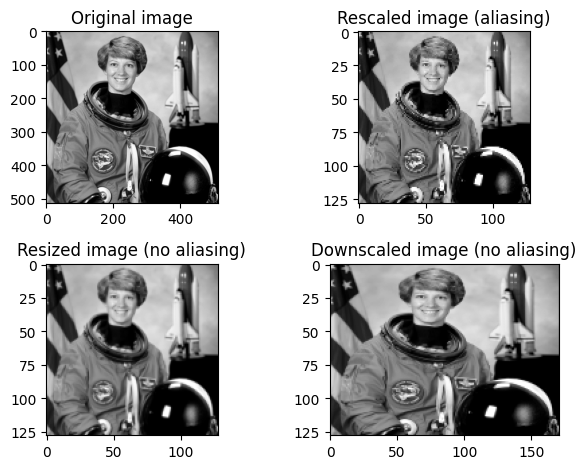

In [ ]:
############ Scaling ##########

import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image = color.rgb2gray(data.astronaut())

image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

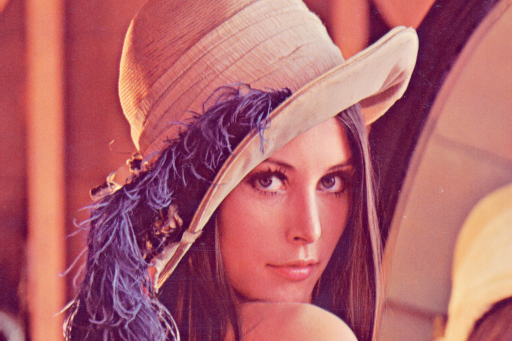

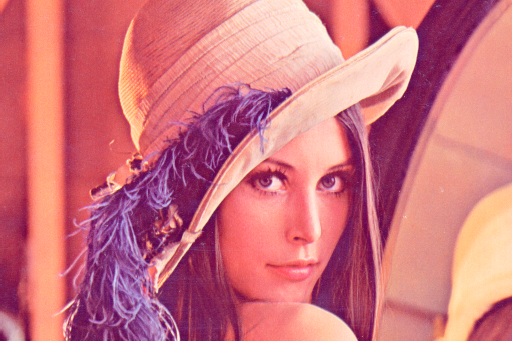

In [ ]:
############ Brightness ##########
from google.colab.patches import cv2_imshow


def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value


    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

image = cv2.imread("lenna_rectangle.png")
frame = increase_brightness(image, value=30)
cv2_imshow(image)
cv2_imshow(frame)


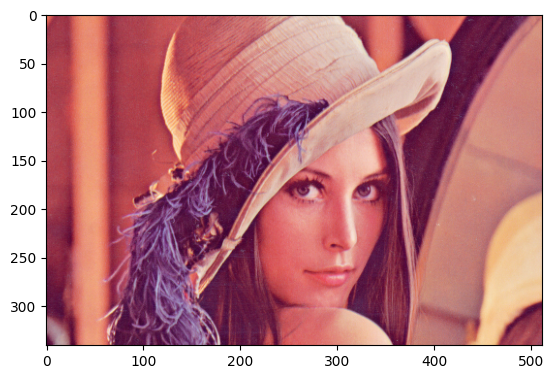

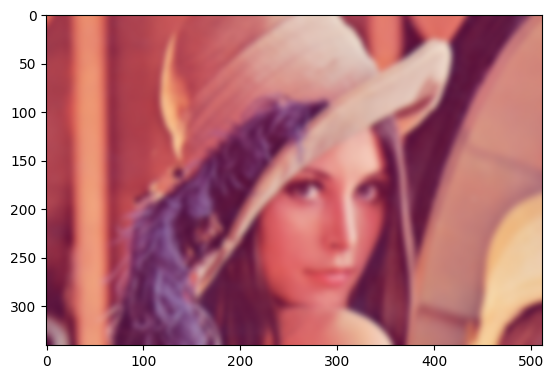

In [ ]:
############ Blurring ##########


import imageio.v3 as iio
#import ipympl
import matplotlib.pyplot as plt
import skimage as ski

image = iio.imread("lenna_rectangle.png")

# display the image
fig, ax = plt.subplots()
plt.imshow(image)

sigma = 3.0

# apply Gaussian blur, creating a new image
blurred = ski.filters.gaussian(
    image, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)

# display blurred image
fig, ax = plt.subplots()
plt.imshow(blurred)

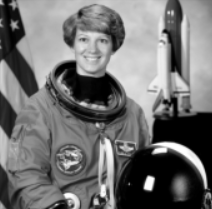

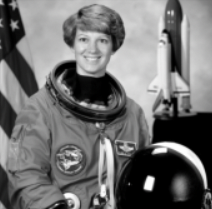

(209, 212, 3)

In [ ]:
############ gaussian noise ##########





import numpy as np
import os
import cv2
def noisy(image):

    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

image = cv2.imread("astronaut.PNG")

noisy_image = noisy(image)
cv2_imshow(image)
cv2_imshow(noisy_image)
image.shape

True

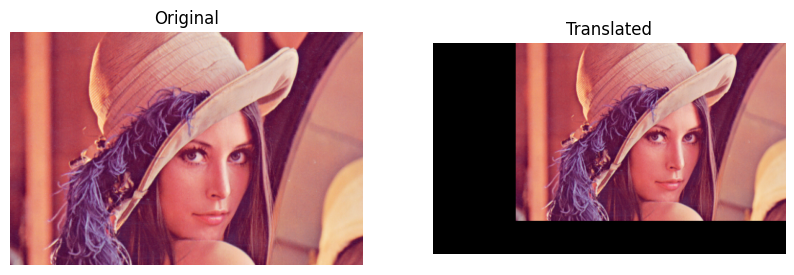

In [ ]:
############ displacement ##########

import numpy as np
import cv2
import json
from matplotlib import pyplot as plt


def pad_vector(vector, how, depth, constant_value=0):
    vect_shape = vector.shape[:2]
    if (how == 'upper') or (how == 'top'):
        pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
        pv = np.vstack(tup=(pp, vector))
    elif (how == 'lower') or (how == 'bottom'):
        pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
        pv = np.vstack(tup=(vector, pp))
    elif (how == 'left'):
        pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
        pv = np.hstack(tup=(pp, vector))
    elif (how == 'right'):
        pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
        pv = np.hstack(tup=(vector, pp))
    else:
        return vector
    return pv


def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src


def shifter(vect, y, y_):
    if (y > 0):
        image_trans = pad_vector(vector=vect, how='lower', depth=y_)
    elif (y < 0):
        image_trans = pad_vector(vector=vect, how='upper', depth=y_)
    else:
        image_trans = vect
    return image_trans


def shift_image(image_src, at):
    x, y = at
    x_, y_ = abs(x), abs(y)

    if (x > 0):
        left_pad = pad_vector(vector=image_src, how='left', depth=x_)
        image_trans = shifter(vect=left_pad, y=y, y_=y_)
    elif (x < 0):
        right_pad = pad_vector(vector=image_src, how='right', depth=x_)
        image_trans = shifter(vect=right_pad, y=y, y_=y_)
    else:
        image_trans = shifter(vect=image_src, y=y, y_=y_)

    return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=False):
    if len(at) != 2: return False

    image_src = read_this(image_file=image_file, gray_scale=gray_scale)

    if not gray_scale:
        r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
        r_trans = shift_image(image_src=r_image, at=at)
        g_trans = shift_image(image_src=g_image, at=at)
        b_trans = shift_image(image_src=b_image, at=at)
        image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
    else:
        image_trans = shift_image(image_src=image_src, at=at)

    if with_plot:
        cmap_val = None if not gray_scale else 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

        ax1.axis("off")
        ax1.title.set_text('Original')

        ax2.axis("off")
        ax2.title.set_text("Translated")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_trans, cmap=cmap_val)
        return True
    return image_trans


translate_this(
    image_file='lena.PNG',
    at=(150, 60),
    with_plot=True
)

In [ ]:






# function 1
def displacement(img):
  ## To Do

  return img

# function 2
def rotation(img):
    ## To Do    https://www.pythonpool.com/python-rotate-image/


    input_image = np.array(Image.open(img))

    img = Image.fromarray(np.rot90(input_image))

    return img


# function 3
def scaling(img):
  ## To Do

  input_image = np.array(Image.open(img))


  return img



# function 4
def Brightness(img):  ## for augmentation
  ## To Do

  return img



# function 5
def bluring(img):# for augmentation
  ## To Do

  return img

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do

  return img





In [ ]:
class CustomDataset(Dataset):

    def __init__(self,):
      ## To Do

    def __getitem__(self,idx):
      ## To Do

    def __len__(self):
      ## To Do


In [ ]:

dataset_train = CustomDataset()## To Do
dataset_test = CustomDataset()## To Do
dataset_val = CustomDataset()## To Do


train_loader = DataLoader()## To Do
test_loader= DataLoader()## To Do
val_loader = DataLoader()## To Do


In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

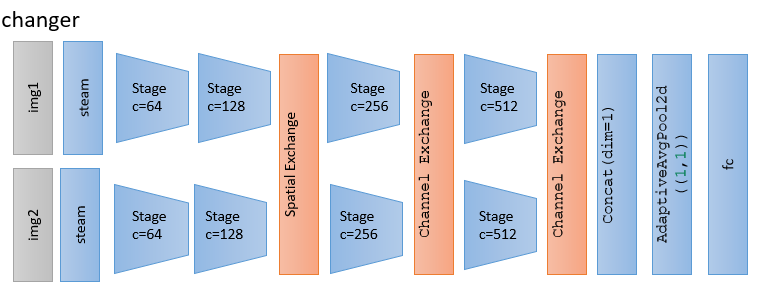

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


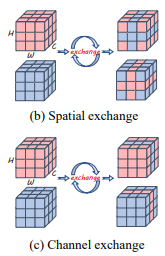

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

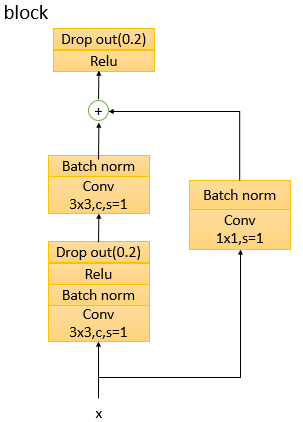

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [ ]:
##To Do
class block(nn.Module):
  def __init__(self,):
    super(block,self).__init__()


  def forward(self,x):


    return out

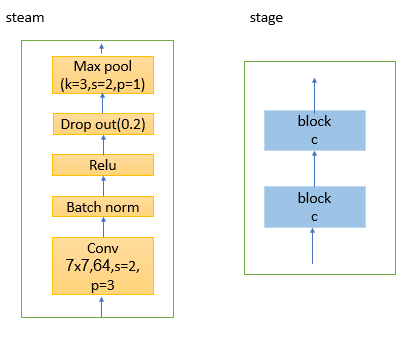

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(

        )

    self.stage1=
    self.stage2=
    self.stage3=
    self.stage4=





  def _make_stage(self,):

    layers=[]

    return nn.Sequential(*layers)




  def forward(self,x1,x2):



    return out

In [ ]:
## To Do
device =


model=changer(ResidualBlock,SpatialExchange,ChannelExchange).to(device)

citeration = ## loss
optimizer= ## optimizer

##Train & validation


In [ ]:

Loss_train=[]
Loss_val=[]


    print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

print(f' loss_test= {:.3f}, acc_test={()}')


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟